In [1]:
from google.cloud import bigquery
bq = bigquery.Client()

In [2]:
%load_ext google.cloud.bigquery

In [43]:
%%bigquery
SELECT *
FROM cs320-f21.apr28.applications
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,Timestamp,loan_amount,income,latitude,longitude
0,2023-04-18 15:47:56.141000+00:00,200000,75000,43.069610,-89.411429
1,2023-04-18 22:02:45.381000+00:00,500000,125000,43.044469,-89.432674
2,2023-04-19 14:24:42.341000+00:00,350000,80000,44.513755,-88.057333
3,2023-04-20 08:59:51.179000+00:00,190000,150000,43.889848,-91.197627
4,2023-04-25 22:12:49.061000+00:00,250000,25000,43.905450,-89.060410


# Geo Data

In [4]:
# 55 is WI
q = bq.query("""
SELECT county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""")

In [5]:
df = q.to_geodataframe()

In [6]:
type(df)

geopandas.geodataframe.GeoDataFrame

<Axes: >

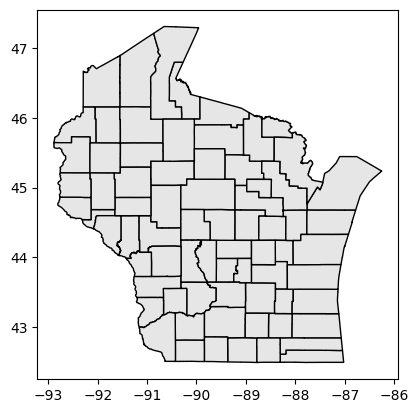

In [7]:
df.plot(edgecolor="k", facecolor="0.9")

# Export/Move Data

In [8]:
with open("export.geojson", "w") as f:
    f.write(df.to_json())

In [9]:
q = bq.query("""
CREATE OR REPLACE TABLE cs320-f21.apr28.wi
AS

SELECT county_name, county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55' -- is WI
""")

In [10]:
q.to_dataframe()

""


# Aggregates

In [11]:
q = bq.query("""
SELECT ST_UNION_AGG(county_geom)
FROM cs320-f21.apr28.wi
""")

In [12]:
wi = q.to_geodataframe()

<Axes: >

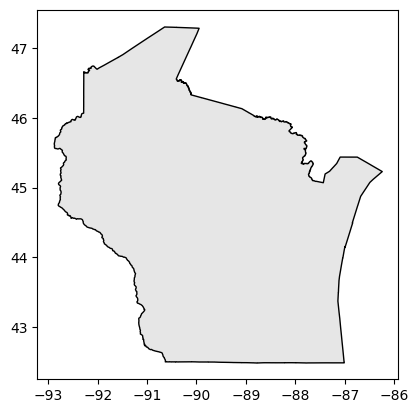

In [13]:
wi.plot(edgecolor="k", facecolor="0.9")

In [14]:
q = bq.query("""
SELECT ST_CENTROID(county_geom)
FROM cs320-f21.apr28.wi
""")
center_df = q.to_geodataframe()
center_df.head()

,f0_
0,POINT (-90.61780 43.94559)
1,POINT (-88.70752 43.41617)
2,POINT (-90.70615 42.86720)
3,POINT (-88.70992 45.00437)
4,POINT (-90.83455 43.59403)


<Axes: >

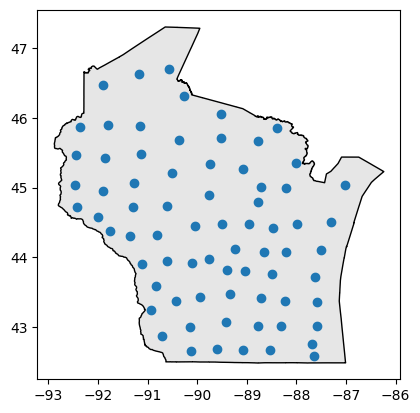

In [15]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
center_df.plot(ax=ax)

In [16]:
q = bq.query("""
SELECT ST_CENTROID_AGG(county_geom)
FROM cs320-f21.apr28.wi
""")
center_df = q.to_geodataframe()
center_df.head()

,f0_
0,POINT (-89.70967 44.62668)


<Axes: >

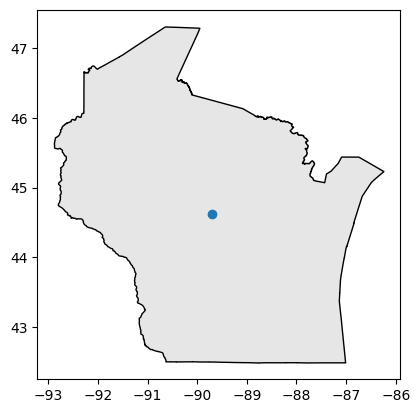

In [17]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
center_df.plot(ax=ax)

# Create Houses with Geographic Column from form data

In [18]:
%%bigquery
CREATE OR REPLACE TABLE cs320-f21.apr28.houses

AS

SELECT *, ST_GEOGPOINT(longitude, latitude) AS loc
FROM cs320-f21.apr28.applications

Query is running:   0%|          |

""


In [19]:
q = bq.query("""
SELECT loc
FROM cs320-f21.apr28.houses
WHERE (latitude BETWEEN 40 and 60) AND (longitude BETWEEN -100 and -75)
""")
houses_df = q.to_geodataframe()
houses_df.head(3)

,loc
0,POINT (-89.53040 43.03731)
1,POINT (-89.40123 43.07305)
2,POINT (-91.58525 45.63762)


<Axes: >

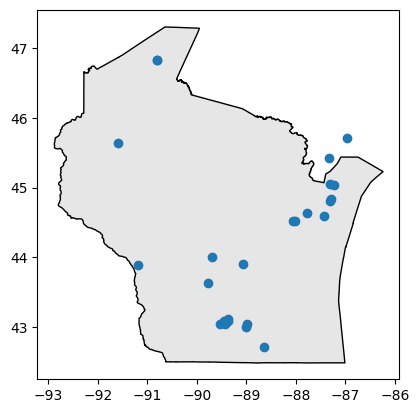

In [20]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
houses_df.plot(ax=ax)

In [21]:
# ST_WITHIN, ST_DWITHIN

In [22]:
q = bq.query("""
SELECT loc, county_name
FROM cs320-f21.apr28.houses, cs320-f21.apr28.wi
WHERE ST_WITHIN(houses.loc, wi.county_geom)
""")
houses_df = q.to_geodataframe()

<Axes: >

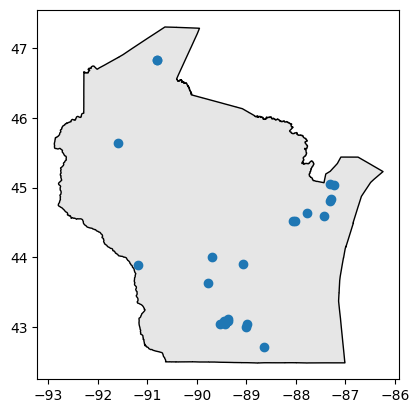

In [23]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
houses_df.plot(ax=ax)

In [24]:
# sort houses by distance to the capitol

# ST_GEOGPOINT(-89.384107, 43.074715)

In [25]:
q = bq.query("""
SELECT *, ST_DISTANCE(houses.loc, ST_GEOGPOINT(-89.384107, 43.074715))/1000 AS km
FROM cs320-f21.apr28.houses
ORDER BY km ASC
LIMIT 10
""")
houses_df = q.to_geodataframe()
houses_df

,Timestamp,loan_amount,income,latitude,longitude,loc,km
0,2023-05-01 23:59:38.191000+00:00,400000,125000,43.085261,-89.378496,POINT (-89.37850 43.08526),1.258098
1,2023-04-30 13:04:10.189000+00:00,750000,200000,43.073051,-89.401230,POINT (-89.40123 43.07305),1.403071
2,2023-04-30 20:25:21.899000+00:00,200000,95000,43.073051,-89.401230,POINT (-89.40123 43.07305),1.403071
3,2023-04-26 17:29:54.788000+00:00,10000000,10000000,43.072125,-89.403310,POINT (-89.40331 43.07212),1.586126
4,2023-04-30 22:57:40.311000+00:00,500000,200000,43.069820,-89.407370,POINT (-89.40737 43.06982),1.966420
5,2023-04-29 16:39:33.583000+00:00,20000000,2000000,43.073464,-89.409162,POINT (-89.40916 43.07346),2.039862
6,2023-04-18 15:47:56.141000+00:00,200000,75000,43.069610,-89.411429,POINT (-89.41143 43.06961),2.290741
7,2023-04-30 20:30:17.753000+00:00,523842,250000,43.076600,-89.412500,POINT (-89.41250 43.07660),2.315663
8,2023-05-01 18:34:28.222000+00:00,10000000,500000,43.108772,-89.369592,POINT (-89.36959 43.10877),3.966107
9,2023-04-18 22:02:45.381000+00:00,500000,125000,43.044469,-89.432674,POINT (-89.43267 43.04447),5.184624


In [26]:
# which houses are within a radius (10 km) of each county centroid?
q = bq.query("""
SELECT loc, county_name
FROM cs320-f21.apr28.houses, cs320-f21.apr28.wi
WHERE ST_DWITHIN(houses.loc, ST_CENTROID(wi.county_geom), 10000)
""")
houses_df = q.to_geodataframe()
houses_df

,loc,county_name
0,POINT (-89.69588 43.99855),Adams
1,POINT (-89.40737 43.06982),Dane
2,POINT (-89.40123 43.07305),Dane
3,POINT (-89.43267 43.04447),Dane
4,POINT (-89.40331 43.07212),Dane
5,POINT (-89.41143 43.06961),Dane
6,POINT (-89.40916 43.07346),Dane
7,POINT (-89.45000 43.08400),Dane
8,POINT (-89.53040 43.03731),Dane
9,POINT (-89.40123 43.07305),Dane


# Approximations

1. privacy
2. machine learning

In [27]:
# privacy
q = bq.query("""
SELECT ST_SNAPTOGRID(loc, 0.1)
FROM cs320-f21.apr28.houses
""")
q.to_geodataframe().head(5)

,f0_
0,POINT (-90.00000 -23.00000)
1,POINT (10.00000 20.00000)
2,POINT (99.10000 19.40000)
3,POINT (89.40000 43.10000)
4,POINT (40.80000 74.00000)


In [28]:
# preprocessing for ML
q = bq.query("""
SELECT loc, ST_GEOHASH(loc, 4)
FROM cs320-f21.apr28.houses
""")
q.to_dataframe()

,loc,f0_
0,POINT(-90 -23),3gzv
1,POINT(10 20),s5x1
2,POINT(99.1332 19.4326),w5qq
3,POINT(89.4008 43.0722),tzxt
4,POINT(40.7587 73.9787),uvhu
...,...,...
57,POINT(87.0471 45.1114),vbjb
58,POINT(-87.222494 45.031929),f01b
59,POINT(-91.197627 43.889848),9zz1
60,POINT(-89.411429 43.06961),dp8m


# Machine Learning

In [29]:
import pandas as pd
import numpy as np
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = df["x1"] + df["x2"] + np.random.rand(len(df))
df.head()

,x1,x2,y
0,4.0,1.0,5.505525
1,7.0,2.0,9.290891
2,8.0,2.0,10.707579
3,8.0,0.0,8.070157
4,4.0,0.0,4.426883


In [32]:
df.to_gbq("cs320-f21.apr28.tbl1", if_exists="replace")

100%|██████████| 1/1 [00:00<00:00, 2896.62it/s]


In [33]:
%%bigquery
CREATE OR REPLACE TABLE cs320-f21.apr28.traintest

AS

SELECT *, rand() < 0.25 AS test
FROM cs320-f21.apr28.tbl1

Query is running:   0%|          |

""


In [34]:
%%bigquery
CREATE OR REPLACE MODEL `cs320-f21.apr28.mymodel`
OPTIONS(model_type='LINEAR_REG', INPUT_LABEL_COLS=['y'])

AS

SELECT x1, x2, y
FROM `cs320-f21.apr28.traintest`
WHERE NOT test

Query is running:   0%|          |

""


In [35]:
%%bigquery
SELECT * FROM
ML.WEIGHTS(MODEL `cs320-f21.apr28.mymodel`)

Query is running:   0%|          |

Downloading:   0%|          |

,processed_input,weight,category_weights
0,x1,0.990507,[]
1,x2,0.951117,[]
2,__INTERCEPT__,0.591509,[]


In [36]:
%%bigquery
SELECT *
FROM
ML.PREDICT(
    MODEL `cs320-f21.apr28.mymodel`,
    (
        SELECT x1, x2, y
        FROM `cs320-f21.apr28.traintest`
        WHERE test
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_y,x1,x2,y
0,2.493743,0.0,2.0,2.565619
1,1.542626,0.0,1.0,1.658783
2,1.542626,0.0,1.0,1.942090
3,2.572524,2.0,0.0,2.625179
4,4.474758,2.0,2.0,4.093848
5,3.563031,3.0,0.0,3.933397
6,3.563031,3.0,0.0,3.127605
7,4.514148,3.0,1.0,4.051870
8,4.514148,3.0,1.0,4.459249
9,4.553538,4.0,0.0,4.160857


In [37]:
%%bigquery
SELECT 5 AS x1, 8 AS x2

Query is running:   0%|          |

Downloading:   0%|          |

,x1,x2
0,5,8


In [38]:
%%bigquery
SELECT *
FROM
ML.PREDICT(
    MODEL `cs320-f21.apr28.mymodel`,
    (
        SELECT 5 AS x1, 8 AS x2
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_y,x1,x2
0,13.152982,5,8


In [39]:
%%bigquery df
SELECT *
FROM
ML.EVALUATE(
    MODEL `cs320-f21.apr28.mymodel`,
    (
        SELECT x1, x2, y
        FROM `cs320-f21.apr28.traintest`
        WHERE test
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
df.iloc[0].at["r2_score"]

0.991924833278191

# Transformers

In [45]:
import pandas as pd
import numpy as np
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = df["x1"] ** 2 - 3 * df["x2"] + np.random.rand(len(df))
df.head(3)

,x1,x2,y
0,0.0,1.0,-2.232229
1,3.0,0.0,9.184795
2,4.0,0.0,16.491299


In [46]:
df.to_gbq("cs320-f21.apr28.tbl2", if_exists="replace")

100%|██████████| 1/1 [00:00<00:00, 3184.74it/s]


In [50]:
%%bigquery
CREATE OR REPLACE MODEL `cs320-f21.apr28.m1`
OPTIONS(model_type='LINEAR_REG', INPUT_LABEL_COLS=['y'])

AS

SELECT x1,x2,y
FROM `cs320-f21.apr28.tbl2`

Query is running:   0%|          |

""


In [52]:
%%bigquery
SELECT *
FROM ML.EVALUATE(
    MODEL `cs320-f21.apr28.m1`, 
    (
        SELECT x1,x2,y
        FROM `cs320-f21.apr28.tbl2`
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,6.419158,54.295212,0.131061,6.23388,0.905991,0.905991


In [54]:
%%bigquery
SELECT x1,x2,POWER(x1,2) AS x1_2,POWER(x2,2) AS x2_2,x1*x2 AS x1_x2, y
FROM (
    SELECT x1,x2,y
    FROM `cs320-f21.apr28.tbl2`
)

Query is running:   0%|          |

Downloading:   0%|          |

,x1,x2,x1_2,x2_2,x1_x2,y
0,0.0,0.0,0.0,0.0,0.0,0.080550
1,0.0,0.0,0.0,0.0,0.0,0.312220
2,0.0,0.0,0.0,0.0,0.0,0.412525
3,2.0,0.0,4.0,0.0,0.0,4.743423
4,2.0,0.0,4.0,0.0,0.0,4.251724
...,...,...,...,...,...,...
95,7.0,1.0,49.0,1.0,7.0,46.983689
96,8.0,1.0,64.0,1.0,8.0,61.475771
97,9.0,1.0,81.0,1.0,9.0,78.007638
98,9.0,1.0,81.0,1.0,9.0,78.921284


## with polynomial transformation

In [55]:
%%bigquery
CREATE OR REPLACE MODEL `cs320-f21.apr28.m2`
TRANSFORM(x1,x2,POWER(x1,2) AS x1_2,POWER(x2,2) AS x2_2,x1*x2 AS x1_x2, y)
OPTIONS(model_type='LINEAR_REG', INPUT_LABEL_COLS=['y'])

AS

SELECT x1,x2,y
FROM `cs320-f21.apr28.tbl2`

Query is running:   0%|          |

""


In [58]:
%%bigquery df
SELECT "linear" AS model, r2_score
FROM ML.EVALUATE(
    MODEL `cs320-f21.apr28.m1`, 
    (
        SELECT x1,x2,y
        FROM `cs320-f21.apr28.tbl2`
    )
)
UNION ALL
SELECT "polynomial" AS model, r2_score
FROM ML.EVALUATE(
    MODEL `cs320-f21.apr28.m2`, 
    (
        SELECT x1,x2,y
        FROM `cs320-f21.apr28.tbl2`
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [59]:
df

,model,r2_score
0,polynomial,0.999861
1,linear,0.905991


Text(0, 0.5, 'R^2 score')

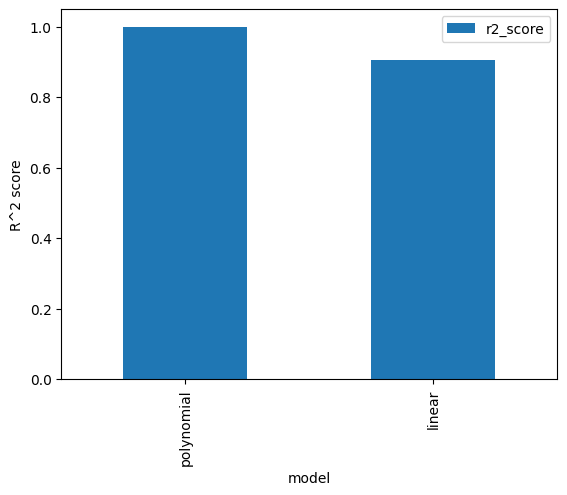

In [62]:
ax = df.set_index("model").plot.bar()
ax.set_ylabel("R^2 score")

## Handle Categorical Data

In [63]:
df = pd.DataFrame({"x1": np.random.choice(["A", "B", "C"], 100), 
                   "x2": np.random.randint(0, 10, 100).astype(float)})
df["y"] = df["x1"].map({"A":1, "B":5, "C":15}) + 2 * df["x2"] + np.random.rand(len(df))
df.head()

,x1,x2,y
0,B,5.0,15.518597
1,A,1.0,3.618496
2,B,2.0,9.118783
3,C,7.0,29.426882
4,B,0.0,5.910254


In [65]:
df.to_gbq("cs320-f21.apr28.tbl3", if_exists="replace")

100%|██████████| 1/1 [00:00<00:00, 5932.54it/s]


In [66]:
%%bigquery
CREATE OR REPLACE MODEL `cs320-f21.apr28.m3`
OPTIONS(model_type='LINEAR_REG', INPUT_LABEL_COLS=['y'])

AS

SELECT x1,x2,y
FROM `cs320-f21.apr28.tbl3`

Query is running:   0%|          |

""


In [67]:
%%bigquery df
SELECT *
FROM ML.WEIGHTS(MODEL `cs320-f21.apr28.m3`)

Query is running:   0%|          |

Downloading:   0%|          |

In [69]:
df.set_index("processed_input")

,weight,category_weights
processed_input,,
x1,NaN,"[{'category': 'B', 'weight': 4.088409769536576..."
x2,1.998761,[]
__INTERCEPT__,1.442398,[]


In [72]:
weights = df.set_index("processed_input").at["x1", "category_weights"].tolist()
weights

[{'category': 'B', 'weight': 4.088409769536576},
 {'category': 'A', 'weight': 0.0},
 {'category': 'C', 'weight': 14.050245665334792}]

<Axes: xlabel='category'>

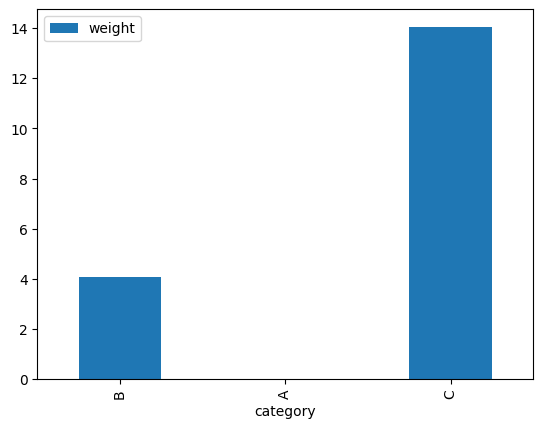

In [75]:
pd.DataFrame(weights).set_index("category").plot.bar()

# Cost Management

In [76]:
q = bq.query("""
SELECT * FROM bigquery-public-data.geo_us_boundaries.counties
""", job_config=bigquery.QueryJobConfig(dry_run=True))

In [78]:
q.total_bytes_processed / 1024**2

182.43214321136475

In [80]:
# geometric polygons, etc use a LOT of space
q = bq.query("""
SELECT county_geom FROM bigquery-public-data.geo_us_boundaries.counties
""", job_config=bigquery.QueryJobConfig(dry_run=True))
q.total_bytes_processed / 1024**2

181.97120666503906

In [81]:
q = bq.query("""
SELECT county_name FROM bigquery-public-data.geo_us_boundaries.counties
""", job_config=bigquery.QueryJobConfig(dry_run=True))
q.total_bytes_processed / 1024**2

0.027889251708984375

In [82]:
q = bq.query("""
SELECT * FROM bigquery-public-data.geo_us_boundaries.counties
""", job_config=bigquery.QueryJobConfig(maximum_bytes_billed = 100 * 1024**2)) # 100 MB

In [83]:
q.to_dataframe()

InternalServerError: 500 Query exceeded limit for bytes billed: 104857600. 191889408 or higher required.

Location: US
Job ID: 24f2175e-1e7b-4bbd-aa8b-4a0dd0fcd407


In [87]:
%%bigquery df
SELECT query, total_bytes_billed/POWER(1024,3) as gb
FROM `cs320-f21.region-us.INFORMATION_SCHEMA.JOBS_BY_PROJECT`
ORDER BY total_bytes_billed DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [90]:
print(df.at[0, "query"])

CREATE OR REPLACE MODEL `cs320-f21.apr24.m3`
OPTIONS(input_label_cols=["y"], model_type="dnn_regressor", hidden_units=[16,8])
AS

SELECT x1, x2, y
FROM `cs320-f21.apr24.tbl1`


In [88]:
df

,query,gb
0,CREATE OR REPLACE MODEL `cs320-f21.apr24.m3`\n...,16.174805
1,\nCREATE OR REPLACE MODEL p7.loan_lr\nOPTIONS(...,15.381836
2,CREATE OR REPLACE TABLE `cs320-f21.apr24.roads...,8.860352
3,"select license, COUNT(*) as count\nfrom bigque...",0.233398
4,"\nselect license, COUNT(*) as count\nfrom bigq...",0.233398
5,"select license, COUNT(*)\nfrom bigquery-public...",0.233398
6,"\nselect license, COUNT(*) as count\nfrom bigq...",0.233398
7,"\nselect license, COUNT(*) as count\nfrom bigq...",0.233398
8,\nSELECT *\nFROM `cs320-f21.p7.hdma` AS hdma\n...,0.201172
9,\nSELECT *\nFROM \n bigquery-public-data.gi...,0.190430
